In [37]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import string
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import mean_squared_error
import math

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [4]:
#read json file
reviews=[]
with open('reviews.json') as f:
    for line in f:
        reviews.append(json.loads(line))
reviews = reviews[0]

#make a list of the reviews
review_num = len(reviews['Id'])
corpus = list()
labels = list()
for i in range(review_num):
    corpus.append(reviews['clean'][str(i)])
    labels.append(reviews['Score'][str(i)])
    
stop_words = ['<', '>', 'br']

In [42]:
#def functions

def svd(data_mat, components):
    svd = TruncatedSVD(n_components=components, n_iter=10)
    svd_mat = svd.fit_transform(data_mat)
    y = np.zeros([components])
    total = 0
    count = 0
    for i in svd.explained_variance_ratio_:
        y[count] = i + total
        count = count + 1
        total = total + i
    plt.figure()
    plt.scatter(range(components), y)
    plt.title("Percent Variance Explained")
    return svd_mat

def split_into_test_and_train(data_mat, labels, training_ind):
    #separate into testing and training
    training = data_mat[0:training_ind]
    training_labels = labels[0:training_ind]
    testing = data_mat[training_ind+1:review_num-1]
    testing_labels = labels[training_ind+1:review_num-1]
#     print("checking train and test shapes")
#     print(training.shape)
#     print(len(training_labels))
#     print(testing.shape)
#     print(len(testing_labels))
    return training, training_labels, testing, testing_labels

def train_lin_reg(training_data, train_labels, testing_data, test_labels):
    reg = LinearRegression()
    reg.fit(training_data, train_labels)
    predictions = reg.predict(testing_data)
    predictions = np.array(predictions)
    predictions[predictions<1] = 1
    predictions[predictions>5] = 5
    predictions_rounded = np.round(predictions)
    predictions_rounded = predictions_rounded.astype(int)
    return predictions_rounded, predictions

def show_accuracy(test_labels, preds_rounded):
    testing_labels_arr = np.array(test_labels)
    correct = sum((testing_labels_arr == preds_rounded))
    acc = correct/len(testing_labels_arr)
    print("Accuracy: " + str(acc))
    np.random.shuffle(testing_labels_arr)
    correct_random = sum((testing_labels_arr == preds_rounded))
    print("Random Accuracy: " + str(correct_random/len(testing_labels_arr)))
    return acc
    
def root_mean_sq_error(preds, test_labels):
    rmse = mean_squared_error(test_labels, preds, squared=False)
    return rmse


In [6]:
# count vectorize
vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1, 1), max_df=0.99, min_df=0.01)
X = vectorizer.fit_transform(corpus)
vocab = vectorizer.get_feature_names()
spar_mat_count = csr_matrix(X.toarray())
print("Len vocab")
print(len(vocab))

# td idf
trans = TfidfTransformer()
X_tf = trans.fit_transform(X)
spar_mat_tf = csr_matrix(X_tf.toarray())

Len vocab
607


In [ ]:
# process 


# components = [25, 50, 100, 200, 300]
# precisions = np.zeros([2, len(components_num)])
# recalls = np.zeros([2, len(components_num)])
# rmses = np.zeros([2, len(components_num)])
# accuracies = np.zeros([2, len(components_num)])
# confusion_mats = [list(), list()]

# scores = {"precisions":precisions, 
#           "recalls": recalls, 
#           "rmses":rmses,
#           "accuracies": accuracies,
#           "confusion_mats": confusion_mats
#          }

cm_labels = ['1', '2', '3', '4', '5']
scores["predictions_rounded"] = [list(), list()]

for j in range(len(components)):
    training_ind = 500000
    models = [spar_mat_count, spar_mat_tf]
    name = ["Count vectorizer", "tf-idf vectors"]
    for i in range(len(models)):
        print(name[i])
        print("dimensions: " +  str(components[j]))
        svd_mat = svd(models[i], components[j])
        train, train_labs, test, test_labs = split_into_test_and_train(svd_mat, labels, training_ind)
        predictions_rounded, predictions = train_lin_reg(train, train_labs, test, test_labs)
        scores["predictions_rounded"][i].append(predictions_rounded)
#         acc = show_accuracy(test_labs, predictions_rounded)
#         cm = confusion_matrix(test_labs, predictions_rounded)
#         disp = ConfusionMatrixDisplay(cm, display_labels = cm_labels)
#         precision = precision_score(test_labs, predictions_rounded, average = None)
#         print('Precision2: %.3f' % np.mean(precision))
#         recall = recall_score(test_labs, predictions_rounded, average = None)
#         print('Recall2: %.3f' % np.mean(recall))
        rmse = root_mean_sq_error(predictions, test_labs)
        print("root mean squared error: " + str(rmse))
        print("\n")
#         scores["recalls"][i,j] = np.mean(recall)
#         scores["precisions"][i,j] = np.mean(precision)
#         scores["accuracies"][i,j] = acc
        scores["rmses"][i,j] =  rmse
#         scores["confusion_mats"][i].append(disp)
        
              
              
              

Count vectorizer
dimensions: 25
root mean squared error: 1.199743441446051


tf-idf vectors
dimensions: 25
root mean squared error: 1.1677467540638695


Count vectorizer
dimensions: 50
root mean squared error: 1.1815804787832536


tf-idf vectors
dimensions: 50
root mean squared error: 1.119977583878152


Count vectorizer
dimensions: 100


In [14]:
np.sum(np.diag(cm))

20292

In [31]:
scores

{'precisions': array([[0.31933856, 0.32480914, 0.33611268, 0.3656678 , 0.37059046],
        [0.25684779, 0.26891377, 0.47163637, 0.43336758, 0.44302853]]),
 'recalls': array([[0.23244721, 0.23611287, 0.24946334, 0.26603973, 0.27432223],
        [0.24861568, 0.26890617, 0.28440095, 0.29177747, 0.30016268]]),
 'rmses': array([[0.41632006, 0.41043231, 0.39680956, 0.38462913, 0.37603908],
        [0.40572445, 0.38979054, 0.37597728, 0.36654626, 0.3604367 ]]),
 'accuracies': array([[0.296938  , 0.3094139 , 0.336557  , 0.36162566, 0.37924385],
        [0.33563665, 0.37540174, 0.4006311 , 0.41585344, 0.42721907]]),
 'confusion_mats': [[<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x1a43b98110>,
   <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x1a437d8510>]]}

<Figure size 432x288 with 0 Axes>

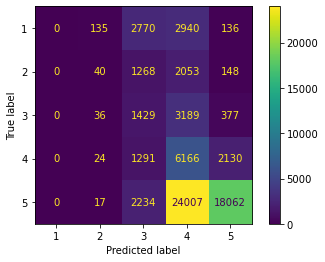

In [36]:
mat_1 = scores['confusion_mats'][1][1]
plt.figure()
mat_1.plot()